---
---
# Stock prices forecast

Dedicaremos este *notebook* a analizar una de las aplicaciones de las series temporales más populares, como es el análisis financiero de valores de mercado. De forma concreta, veremos cómo aplicar una estrategia de mercado para obtener rentabilidades.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from dateutil.relativedelta import relativedelta
#API y más
import yfinance as yf
import itertools

ModuleNotFoundError: No module named 'yfinance'

## Introducción

En un contexto formal, podríamos decir que una muestra empírica de datos $\{x_t\}_{t\in T}$ es una evidencia de una distribución conjunta de variables aleatorias $\{X_t\}_{t\in T}$. A pesar de que estas muestras son finitas, a la hora de dar un marco general a las mismas es conveniente considerar una colección infinita de ellas, a lo que llamaremos **proceso estocástico**. Ello nos lleva al estudio de distribuciones de probabilidad conjuntas del tipo

$$P[X_1\leq x_1,\ldots,X_n\leq x_n],\quad \forall n\in\mathbb{N}$$

Esto induce hablar, dado un proceso estocástico $\{X_t\}_{t\in T}$, de la **familia de distribuciones de probabilidad** asociadas, definida precisamente por 

$$F_{\mathbf{t}}(\mathbf{x})=P[X_1\leq x_1,\ldots,X_n\leq x_n],\quad \mathbf{t}\in \mathcal{T}$$

donde $\mathcal{T}=\{(t_1,\ldots,t_n)\in T^n : t_1< t_2<\ldots< t_n,\, n = 1,2,\ldots\}$. El recíproco (es decir, estudiar si una familia de funciones se corresponde a distribuciones de un proceso estocástico) viene caracterizado bajo una restricción en el conocido *teorema de existencia de Kolmogorov*.

* Ejemplo 1 (Distribuciones binarias): Supongamos que nuestro proceso consiste en lanzar repetidamente una moneda al aire y observar su resultado. Para cada lanzamiento, tendremos que bien el resultado es cara (*-1*), o bien cruz (*1*), con iguales posibilidades; esto es,
$$P[X_n=-1]=P[X_n=1]=\frac{1}{2},\quad n\in\mathbb{N}$$
Es decir, individualmente cada proceso se modela con una distribución $\mathcal{B}(\frac{1}{2})$, lo que nos lleva por reproductividad e independencia de los lanzamientos a que
$$P[X_1= x_1,\ldots,X_n= x_n]=2^{-n},\quad \forall n\in\mathbb{N}$$
donde cada $x_t$  es *-1* ó *1*.

* Ejemplo 2 (*White noise*): Un proceso $\{X_t,\,t\in\mathbb{Z}\}$ se dice que es un *Independent Identically Distributed (IID) noise* con media $0$ y varianza $\sigma^2$ cuando todas esas variables cumplen que $\mathbb{E}[X_t]=0$ y $\text{Var}[X_t]=\sigma^2$. Es claro ahora que el ejemplo 1 no es más que un caso concreto del ejemplo 2 con $\sigma=1$.

Estudiemos, a modo ilustrativo, el primero de los ejemplos:

In [1]:
def coin_flip_experiment(size):
  '''
  Dado un número entero, realiza un número de simulaciones de lanzamiento de dados igual a dicho número, y devuelve la media y varianza de dicho fenómeno
  '''
  #Un poco de control sobre la entrada...
  if (type(size)!=int):
    raise ValueError('El valor introducido no es un número natural.')
  #Simulamos
  results = 2*np.random.binomial(n = 1, p = .5, size = size)-1
  return np.mean(results), np.std(results)

In [4]:
# Fijamos iteraciones
iter = 1000
lag = 3 # los prumeros 3 lanzamientos van a tener un desfase, no va a comenzar en 0, como de prueba(?) nos saltamos los primeros lanzamientos
# Definimos variables
x = range(lag,iter+lag)
mu = np.zeros(iter)
sigma = np.zeros(iter)
# Iteramos para obtener resultados
for i in x:
  mu[i-lag], sigma[i-lag] = coin_flip_experiment(i)

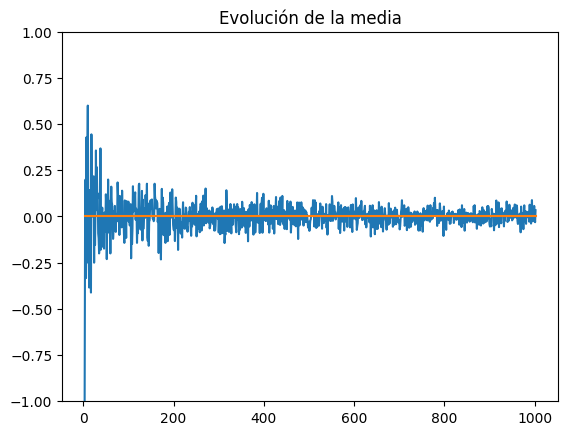

In [5]:
#Dibujamos media
plt.plot(x,mu,x,[0]*iter)
plt.ylim([-1,1])
plt.title('Evolución de la media')
plt.show()

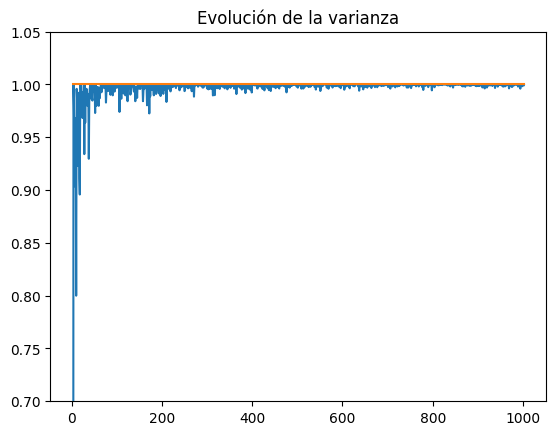

In [6]:
#Dibujamos varianza
plt.plot(x,sigma,x,[1]*iter)
plt.ylim([0.7,1.05])
plt.title('Evolución de la varianza')
plt.show()

Una **serie temporal** se define como un proceso estocástico donde $T\subset \mathbb{Z}$; esto es, donde la indexación de nuestras vv.aa. es entera.

---
## Elementos notables

En lo que se refiere a las series temporales, son de particular interés aquellas que son **estacionarias**, esto es, aquellas cuyas propiedades se mantienen fijas a lo largo del tiempo. Esta idea encaja a la perfección con el concepto de *white noise* introducido anteriormente.

Para tener una noción más precisa de esta idea, es conveniente introducir la siguiente descomposición clásica de las series temporales (aditivas)

$$X_t = m_t+s_t+Y_t,$$

donde: 

* $m_t$ es la *tendencia* del proceso.
* $s_t$ es la *periodicidad* del proceso.
* $Y_t$ es un proceso estacionario.

Nuestro objetivo es, como anticipábamos, ser capaces de absorber los componentes de tendencia y periodicidad con la intención de que el residuo resultante se comporte como un proceso estocástico estacionario, que en el escenario ideal sería un *white noise* de los introducidos anteriormente.

Dos de las formas más habituales de extraer las componentes de tendencia de un proceso son:

* *Moving averages*: consisten en realizar medias acumulativas para suavizar las variaciones de los datos. Usaremos las dos siguientes:
  * *Simple moving average*: $\text{SMA}_t(h)=\frac{1}{h}\sum_{i=0}^{h-1}x_{t+i}$.
  * *Exponential Moving Average*: $\text{EMA}(0)=x_0$, $\text{EMA}(t)=\alpha x_t+(1-\alpha)\text{EMA}(t-1)$, donde $\alpha$ es el **factor de suavizamiento**.

  En la práctica, esta última suele calcularse a partir del *span*, que se traduce en el factor de suavizamiento como: $\alpha = \frac{2}{\text{span}+1}$, con $\text{span}\geq 1$.

* Diferenciación: Definimos el operador diferencia como $\nabla X_t = X_t-X_{t-1}$, y de forma recursiva $\nabla^k X_t=\nabla(\nabla^{k-1} X_t)$. A modo de ejemplo:
$$\nabla^2 X_t=\nabla X_t-\nabla X_{t-1} = X_t-2X_{t-1}+X_{t-2}$$
A la hora de realizar operaciones, sin embargo, parece más eficaz considerar el operador *shift* $(1-B) X_t=\nabla X_t$; así,
$$\nabla^2 X_t=(1-B)^2 X_t=(1-2B+B^2) X_t= X_t-2X_{t-1}+X_{t-2}$$

In [7]:
# Importamos una seie temporal cualquiera
ticker = 'ADA-USD'
period = '60d'
interval = '1h'
data = yf.download(tickers=ticker ,period = period, interval = interval)
data['value'] = (data.loc[:,'High'] + data.loc[:,'Low'])/2
data = data[['value']]
# Calculamos parámetros
SMA = data.rolling(window = 12, min_periods = 1).mean()
EMA = data.ewm(alpha = .5).mean()

NameError: name 'yf' is not defined

In [8]:
# Dibujamos SMAs
sns.set(rc = {'figure.figsize':(20,8)})
sns.lineplot(data = pd.concat([data,
                               data.rolling(window = 7, min_periods = 1).mean(),
                               data.rolling(window = 25, min_periods = 1).mean(),
                               data.rolling(window = 50, min_periods = 1).mean()
                               ],
                              axis = 1,
                              keys = ['series', 'SMA_7', 'SMA_25','SMA_50']
                              )
)

NameError: name 'data' is not defined

In [9]:
# Dibujamos EMAs
sns.set(rc = {'figure.figsize':(20,8)})
sns.lineplot(data = pd.concat([data,
                               data.ewm(span = 7).mean(),
                               data.ewm(span = 25).mean(),
                               data.ewm(span = 50).mean()
                               ],
                              axis = 1,
                              keys = ['series', 'EMA_5', 'EMA_20','EMA_50']
                              )
)

NameError: name 'data' is not defined

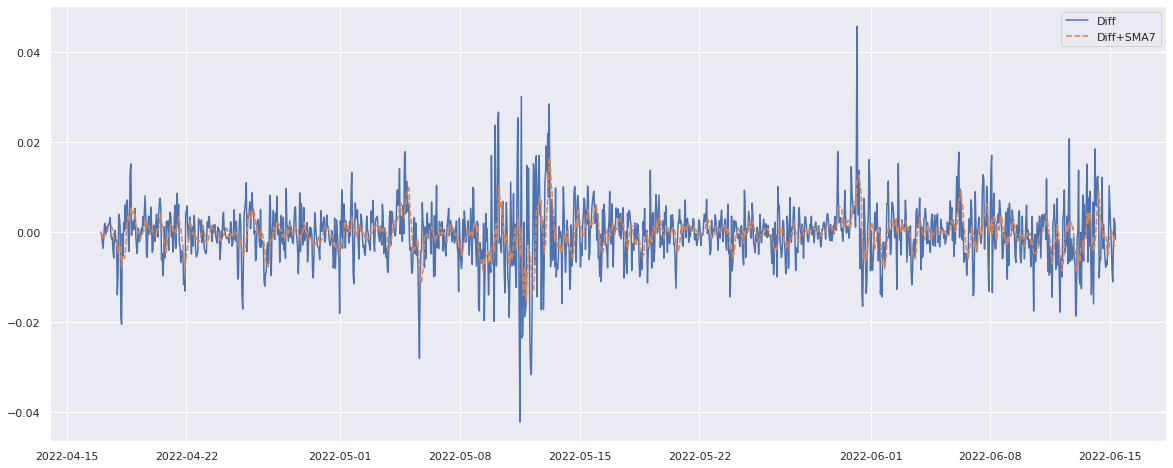

In [10]:
# Dibujamos diferencia
sns.set(rc = {'figure.figsize':(20,8)})
sns.lineplot(data = pd.concat([data.diff().fillna(0),
                               data.diff().fillna(0).rolling(window = 7, min_periods = 1).mean()
                               ],
                              axis = 1,
                              keys = ['Diff', 'Diff+SMA7']
                              )
)

En la práctica, para realizar estimaciones sobre la serie, se aplica en primer lugar la diferenciación, sobre ésta se calcula un *moving average*, y finalmente se deshace el efecto de la diferenciación:

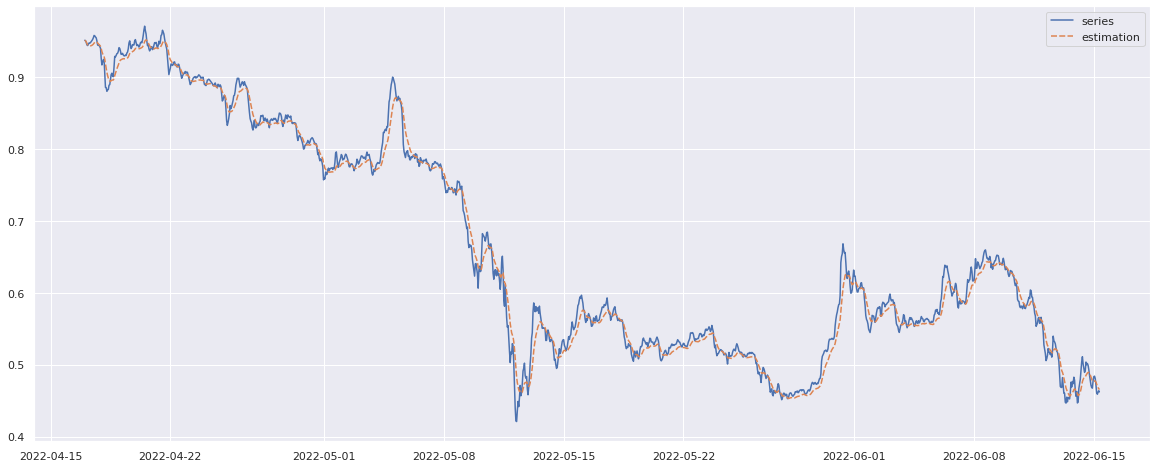

In [11]:
# Estimamos la línea
sns.set(rc = {'figure.figsize':(20,8)})
sns.lineplot(data = pd.concat([data,
                               data.diff().ewm(span = 12).mean().fillna(data.iloc[0]).cumsum()
                               ],
                              axis = 1,
                              keys = ['series', 'estimation']
                              )
)

---
## Estrategia *trading*

A continuación, expondremos una de las estrategias más populares para analizar los momentos de compra-venta. Indicar que, en este caso, se analizarán señales con un alto grado de inestabilidad, por lo que para adaptar estas técnicas econométricas tradicionales puede que requiera de un análisis más sensible.

El indicador MACD (*Moving Average Convergence Divergence*) se calcula de la siguiente forma:

1. Se calculan las *EMA* de orden 12 y 26, y se restan para obtener propiamente la **MACD**:

  `macd = (data.ewm(span=12, adjust=False).mean()-data.ewm(span=26, adjust=False).mean())`

2. A este parámetro, se le calcula una *EMA* de orden 9 para obtener la **señal**:

  `signal = macd.ewm(span=d, adjust=False).mean()`

3. Como diferencia de ambas se obtiene el **histograma**, que será el que nos indique las entradas y salidas al mercado:

  `hist = macd-signal`

Encapsularemos todas estas ideas en un método:

In [12]:
def get_MACD(data, n = 12, m = 26, d = 9):
  '''
  Function that returns, given a DataFrame, the MACD strategy.
  data: DataFrame containing the mean of Open and Close values and DateIndex.
  n: First parameter of EMA.
  m: Second parameter of EMA.
  d: Difference's EMA parameter.
  '''
  macd = (data.loc[:,['value']].ewm(span=n, adjust=False).mean()-data.loc[:,['value']].ewm(span=m, adjust=False).mean())
  macd['type'] = 'macd'
  signal = macd.loc[:,['value']].ewm(span=d, adjust=False).mean()
  signal = pd.DataFrame(signal, columns = ['value'])
  signal['type'] = 'signal'
  dt = pd.concat([macd, signal], axis = 0).sort_index()
  data.loc[:,'histogram'] = (dt.loc[dt['type']=='macd','value']-dt.loc[dt['type']=='signal','value'])
  data.loc[:,'sell_ticks_MACD'] = [np.nan] + [data.loc[data.index[i],'histogram'] if ((data.loc[data.index[i],'histogram']<=0) and (data.loc[data.index[i-1],'histogram']>0)) else np.nan for i in range(1,data.shape[0])]
  data.loc[:,'buy_ticks_MACD'] = [np.nan] + [data.loc[data.index[i],'histogram'] if ((data.loc[data.index[i],'histogram']>=0) and (data.loc[data.index[i-1],'histogram']<0)) else np.nan for i in range(1,data.shape[0])]
  data.loc[:,'ticks_MACD'] = data[['sell_ticks_MACD', 'buy_ticks_MACD']].max(axis = 1)
  data = data.drop(['sell_ticks_MACD', 'buy_ticks_MACD'], axis = 1)
  return data

Podemos ver ahora que, en cada movimiento del histograma, obtenemos una etiqueta con el valor específico, devolviendo el resto de argumentos con un `np.NaN`.

In [ ]:
#Importamos una seie temporal cualquiera
ticker = 'ADA-USD'
period = '60d'
interval = '1h'
data = yf.download(tickers=ticker ,period = period, interval = interval)
data['value'] = (data.loc[:,'High'] + data.loc[:,'Low'])/2
data = get_MACD(data[['value']])

La cuestión ahora es, ¿qué beneficio nos reporta la estrategia que estamos planteando?

In [14]:
def calc_profit(data):
  # Compute first buy date
  first_buy_date = data.loc[data.ticks_MACD>0,:].index[0]
  # Method
  data_profit = data.loc[(~data.ticks_MACD.isnull()) & (data.index>=first_buy_date),:].copy()
  data_profit['pct_change'] = 1 + data_profit.loc[:,'value'].pct_change()
  pct_change = np.prod(data_profit.loc[data_profit.ticks_MACD<0,'pct_change'])
  return pct_change

Analizamos el beneficio de nuestra estrategia anterior:

In [15]:
print('El beneficio del MACD anterior es: {}%'.format(np.round((calc_profit(data)-1)*100,2)))

El beneficio del MACD anterior es: 60.68%


---
---
# Implementación

---
## Métodos auxiliares

In [16]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

---
## Lectura de datos y preprocesamiento una señal

In [17]:
def preprocessing_data(ticker, period, interval, verbose = 0):
  '''
  Attributes:

      path (str): 
          Place where files are to be stored and/or found.
      company (str):
          Signal you want to analyse.
      period (str):
          Days, months, years,...
      interval (str):
          '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'
      n_steps_in (int):
          Number of elements the model takes into account to forecast the next step.
      n_steps_out (int):
          Number of steps the model forecast.
      batch_size (int):
          Number of elements in every set used to estimate loss function gradient.
      verbose (int: 0,1)
          Either showing info about MACD optimal values or not.

  '''
  #Prepare data
  data = yf.download(tickers=ticker ,period = period, interval = interval)
  data = data.iloc[:-1,:] # Remove last ine with non-uniform information pattern
  data['value'] = (data.loc[:,'High'] + data.loc[:,'Low'])/2
  data = data.loc[:,['value']].diff().ewm(span = 12).mean().fillna(data.iloc[0,0]).cumsum()
  #Find optimal strategy
  a = list(np.arange(11,16))
  b = list(np.arange(23,28))
  c = list(np.arange(8,11))
  profit_series = pd.Series({'profit':[]}, index = list(itertools.product(a, b, c)), dtype = 'float')
  for n, m, d in list(itertools.product(a, b, c)):
    profit_series[(n,m,d)] = calc_profit(get_MACD(data, n = n, m = m, d = d))
  bs = profit_series.astype('float').idxmax()
  print('\nOptimal strategy for {}:\n\tn={}\n\tm={}\n\td={}\n\tProfit={}%'.format(ticker, bs[0], bs[1], bs[2], np.round((profit_series[bs]-1)*100,2)))
  #Compute optimal MACD
  signal_MACD = get_MACD(data, n = bs[0], m = bs[1], d = bs[2]).histogram
  if verbose==1:
    print('\nAnalysis properties:\n\tFirst analysis day: {}\n\tFirst buy date: {}\n\tLast sell day: {}\n\tLast day: {}'.format(data.index[0],
                                                                                                                                data.loc[data.ticks_MACD>0,:].index[0],
                                                                                                                                data.loc[data.ticks_MACD<0,:].index[-1],
                                                                                                                                data.index[-1])
          )
    # Plot optimal result
    plt.figure(figsize=(20,5), dpi=80)
    plt.plot(data.index, data.value, label = '{} stock price'.format(ticker))
    plt.scatter(data.loc[data.ticks_MACD>0,:].index, data.loc[data.ticks_MACD>0,'value'], color = 'green', label = 'buy')
    plt.scatter(data.loc[data.ticks_MACD<0,:].index, data.loc[data.ticks_MACD<0,'value'], color = 'red', label = 'sell')
    plt.legend()
    plt.title('MACD optimal strategy. Total rentability: {}%'.format(np.round((profit_series[bs]-1)*100,2)))
    plt.show()
  return pd.concat([data['value'], signal_MACD], axis = 1)

---
## Lectura de datos y preprocesamiento *portfolio*

In [19]:
def preprocessing_data_portfolio(ticker, period, interval, smooth_factor, verbose = 0):
  '''
  Attributes:
      ticker (list):
          Signals you want to analyse in str format.
      period (str):
          Days, months, years,...
      interval (str):
          '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'
      smooth_factor (int):
          EMAs span factor.
      verbose (int: 0,1)
          Either showing info about MACD optimal values or not.
  '''
  # Prepare data
  data = yf.download(tickers=ticker ,period = period, interval = interval)
  data.dropna(inplace = True) # Remove last ine with non-uniform information pattern
  data = (data.xs('High', axis = 1)+data.xs('Low', axis = 1))/2
  data_smooth = (data.diff().ewm(span = smooth_factor).mean()).copy()
  data_smooth.iloc[0,:] = data.iloc[0,:]
  data_smooth = data_smooth.cumsum()
  # Find optimal strategy
  a = list(np.arange(11,16))
  b = list(np.arange(23,28))
  c = list(np.arange(8,11))
  profit_df = pd.DataFrame([], index = list(itertools.product(a, b, c)), columns = data_smooth.columns, dtype = 'float')
  bs_opt = pd.Series([()]*len(ticker), index = data_smooth.columns)
  for col in data_smooth.columns:
    for n, m, d in list(itertools.product(a, b, c)):
      data_copy = data_smooth[[col]].copy()
      data_copy.columns = ['value']
      profit_df.loc[profit_df.index==(n,m,d),col] = calc_profit(get_MACD(data_copy, n = n, m = m, d = d))
    bs_opt[col] = profit_df[col].astype('float').idxmax()
    print('\nOptimal marginal strategy for {}:\n\tn={}\n\tm={}\n\td={}\n\tProfit={}%'.format(col, bs_opt[col][0], bs_opt[col][1], bs_opt[col][2], np.round((profit_df.xs(bs_opt[col]).xs(col)-1)*100,2)))
  # Save histograms and ticks for every signal
  hist_ticks_df = pd.DataFrame([], index = data_smooth.index, columns = pd.MultiIndex.from_tuples(itertools.product(data_smooth.columns, ['value', 'histogram', 'ticks_MACD'])))
  for col in data_smooth.columns:
    data_copy = data_smooth[[col]].copy()
    data_copy.columns = ['value']
    hist_ticks_df.loc[:,col] = get_MACD(data_copy, n = bs_opt[col][0], m = bs_opt[col][1], d = bs_opt[col][2]).values
    hist_ticks_df.loc[:,col].loc[:,'value'] = data.loc[:,col]
  # Portfolio management
  hist_df = hist_ticks_df.xs('histogram', axis = 1, level = 1)
  softmax_df = hist_df.apply(lambda col: (col-min(col))/(max(col)-min(col)), axis = 0).pct_change().mask(hist_df<0).replace(np.NaN,-np.Inf).apply(softmax, axis = 1).replace(np.NaN,0)
  # Profit
  profit = (np.product(np.sum(softmax_df*(hist_ticks_df.xs('value', axis = 1, level = 1).pct_change()+1), axis = 1).replace(0,1))-1)
  print('\nOptimal strategy for portfolio: {}\n\tProfit={}%'.format(ticker, np.round(profit*100,2)))
  if verbose==1:
    # Plotting
    plt.figure(figsize=(20,5), dpi=80)
    for col in data_smooth.columns:
      plt.plot(hist_ticks_df[col].index, hist_ticks_df[col].value/max(hist_ticks_df[col].value), label = '{} stock price'.format(col))
      plt.scatter(hist_ticks_df[col].loc[hist_ticks_df[col].ticks_MACD>0,:].index, hist_ticks_df[col].loc[hist_ticks_df[col].ticks_MACD>0,'value']/max(hist_ticks_df[col].value), color = 'green')
      plt.scatter(hist_ticks_df[col].loc[hist_ticks_df[col].ticks_MACD<0,:].index, hist_ticks_df[col].loc[hist_ticks_df[col].ticks_MACD<0,'value']/max(hist_ticks_df[col].value), color = 'red')
    plt.legend()
    plt.title('Portfolio distribution with in-out indicators (normalised)')
    plt.show()
    print('\n')
    (np.cumprod(np.sum(softmax_df*(hist_ticks_df.xs('value', axis = 1, level = 1).pct_change()+1), axis = 1).replace(0,1))-1).plot(figsize = (16,4), title = 'Profit evolution')
  return hist_ticks_df.xs('histogram', axis = 1, level = 1), bs_opt

---
## Visualización de estrategia óptima

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Optimal strategy for BTC-USD:
	n=11
	m=24
	d=8
	Profit=51.0%

Analysis properties:
	First analysis day: 2022-04-17 00:00:00+00:00
	First buy date: 2022-04-17 12:00:00+00:00
	Last sell day: 2022-06-13 01:00:00+00:00
	Last day: 2022-06-15 07:00:00+00:00


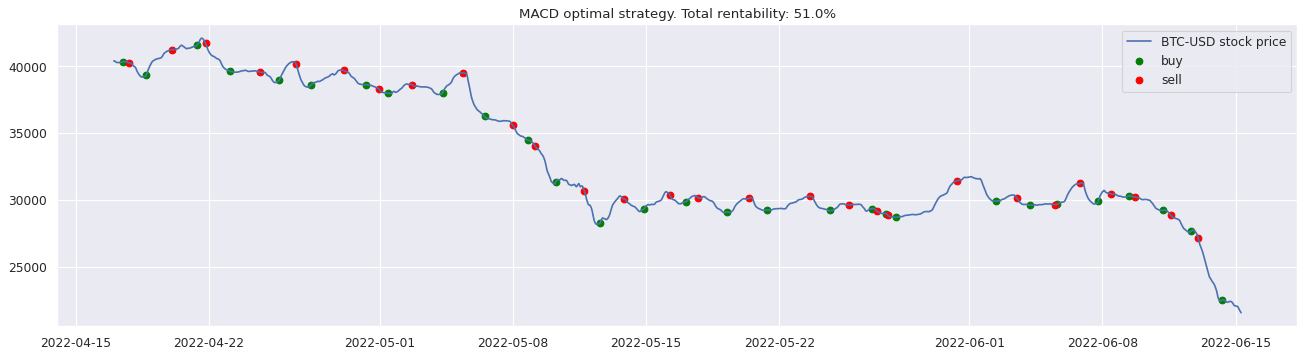

In [25]:
ticker = 'BTC-USD'
period = '60d'
interval = '1h'
#Prepare data
data = preprocessing_data(ticker, period, interval, verbose = 1)